In [1]:
### PYMOO
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.core.sampling import Sampling
from pymoo.core.mutation import Mutation

#multiprocessamento e pymoo
import os
import multiprocessing
from pymoo.core.problem import StarmapParallelization

#Pandas, SKLearn e etc.
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import plotly.express as px
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

#Goatools e Gontosim
from goatools.obo_parser import GODag
from goatools.base import get_godag
import pandas as pd
import requests, sys

#go = get_godag("go-basic.obo", optional_attrs={'relationship'})

from Similarity import Similarity_of_Two_GOTerms, Similarity_of_Set_of_GOTerms

  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2024-06-17) 51,502 Terms; optional_attrs(relationship)


In [2]:
data = pd.read_pickle('Data/data_normalized.pkl')

In [3]:
colunas = list(data.columns)
colunas.remove('samples')
colunas.remove('type')

affymetrix_GO_terms = dict(zip(pd.read_pickle('Data/affymetrix_GO_terms.pkl')['ID'],pd.read_pickle('Data/affymetrix_GO_terms.pkl')['GO term']))

X = data[colunas]
y = data['type']

Funções de Avaliação

In [4]:
def _init_worker():
    global pid_, X_worker, y_worker, colunas_worker
    pid_ = os.getpid()
    X_worker = X.copy()
    y_worker = y.copy()
    colunas_worker = colunas.copy()
    print(pid_)

In [5]:
class GeneSelection(ElementwiseProblem):
    def __init__(self, X, y, runner):
        #self.X = X_worker
        #self.y = y_worker
        self.n_features = X.shape[1]
        self.eval_dict = {'n_features':[], 'f1_score':[]}
        super().__init__(   n_var=self.n_features,
    						n_obj=2,
    						n_constr=0,
    						xl=np.zeros(self.n_features),
    						xu=np.ones(self.n_features),
    						elementwise_evaluation=True,
                            type_var=bool,
                            save_history=True,
                            elementwise_runner=runner)

    def _evaluate(self, x, out, *args, **kwargs):
    	# seleciona as features de acordo com o vetor binário
        selected_features = np.where(x == 1)[-1]
        X_selected = X_worker.iloc[:,selected_features]
    	
        # Kfolding usado para separar em treino e teste
        skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
        #X_train, X_valid, y_train, y_valid = train_test_split(X_selected, self.y, test_size=0.1, random_state=100)
    	
    	# treino usando modelo SVM
        clf = svm.SVC(kernel='linear')

        # compute f_1 and AUC on validation set
        f_1 = np.mean(cross_val_score(clf, X_selected, y_worker, cv=skf, scoring='f1_macro'))
        n_features = len(selected_features)
        # salvar os resultados
        self.eval_dict['n_features'].append(n_features)
        self.eval_dict['f1_score'].append(f_1)
    	
    	# define os objetivos a serem minimizados
        out["F"] = [n_features, -f_1]

In [6]:
class BinaryDistributedRandomSampling(Sampling):

    def _do(self, problem, n_samples, **kwargs):
        population = []
        max = 1000
        ns = []
        for i in range(n_samples):
            trues = np.random.randint(1, max + 1)
            individual = np.array([True] * trues + [False] * (problem.n_var - trues))
            np.random.shuffle(individual)
            population.append(individual)
            ns.append((individual.sum()))
        #print(population)
        print(sorted(ns))
        return population

class BitflipMutationLimited(Mutation):

    def _do(self, problem, X, **kwargs):
        prob_var = self.get_prob_var(problem, size=(len(X), 1))
        Xp = np.copy(X)
        flip = np.random.random(X.shape) < prob_var
        Xp[flip] = ~X[flip]
        for individual in Xp:
            if individual.sum() == 0:
                individual[np.random.choice(range(len(individual))[individual])] = True
            while individual.sum() > 1000:
                individual[np.random.choice(range(len(individual))[individual])] = False
        return Xp

def mutate_individual(individual, past_individual):
    added = individual & ~past_individual
    added_index = np.array(range(len(added)))[added]
    genes_individual = []
    for i in np.array(range(len(individual)))[individual & ~added]:
        genes_individual.extend(affymetrix_GO_terms[colunas[i]])
    if len(genes_individual) > 100:
        genes_individual = np.random.choice(genes_individual, 100)
    #print(genes_individual)         
    #print(added_index)
    for candidate in added_index:
        new_candidate = np.random.choice(np.array(range(len(individual)))[~individual])
        genes_candidate = affymetrix_GO_terms[colunas[candidate]]
        genes_new_candidate = affymetrix_GO_terms[colunas[new_candidate]]
        if (len(genes_candidate) > 0 and len(genes_new_candidate) > 0 and len(genes_individual) > 0):
            score_1 = Similarity_of_Set_of_GOTerms(genes_individual, genes_candidate, 'GOGO')
            score_2 = Similarity_of_Set_of_GOTerms(genes_individual, genes_new_candidate, 'GOGO')
            print(candidate, score_1)
            print(new_candidate, score_2)
            if score_1 >= score_2:
                individual[candidate] = True
                individual[new_candidate] = False
            else:
                individual[candidate] = False
                individual[new_candidate] = True
    return individual
    
class BitflipMutationLimitedGuided(Mutation):

    def _do(self, problem, X, **kwargs):
        prob_var = self.get_prob_var(problem, size=(len(X), 1))
        Xp = np.copy(X)
        flip = np.random.random(X.shape) < prob_var
        Xp[flip] = ~X[flip]
        mutation_pool = multiprocessing.Pool(48)
        pool.starmap(mutate_individual, zip(Xp, X))
        #for individual, past_individual in zip (Xp, X):
        #    individual = mutate_individual(individual, past_individual)
                
        for individual in Xp:
            if individual.sum() == 0:
                individual[np.random.choice(range(len(individual))[individual])] = True
            while individual.sum() > 1000:
                individual[np.random.choice(range(len(individual))[individual])] = False
        return Xp


In [7]:
# initialize the thread pool and create the runner
n_proccess = 48
pool = multiprocessing.Pool(n_proccess, initializer=_init_worker)
runner = StarmapParallelization(pool.starmap)

851357
851355
851363
851356
851353
851369
851359
851361
851370
851364
851354
851366
851358
851367851360

851362
851375
851372
851373
851365851368

851381
851377
851374
851382
851371
851378
851384
851376
851380
851387
851379
851385
851388
851386
851383
851391
851389
851390
851392
851401
851397
851393
851400
851406
851407
851411
851414
2947 0.205
14757 0.243
2404 0.263
589 0.133
6303 0.235
19273 0.178
10543 0.299
19109 0.32
3139 0.259
14796 0.105
21873 0.234
693 0.247
12586 0.273
5248 0.289
7315 0.229
20691 0.267
21204 0.29920288
4741  0.2870.371
19411
 0.366
97 0.234
11574 0.193
14869 0.346
12293 0.252
448 0.294
4700 0.19
8134 0.337
18790 0.359
9005 0.188
15819 0.395
1693 0.288
17556 0.351
1162 0.286
4100 0.317
1816 0.353
175222178  0.2980.207

12408 0.292
5614 0.378
10744 0.285
19276 0.203
642 0.271
6584 0.414
20169 0.327
4803 0.287
12945 0.438
4881 0.194
1437 0.307
2719 0.363
14171 0.212
893311099  0.2820.279

3325120  0.2450.281

9055 0.398
5314 0.192
5288 0.132
19128 0.248
1922 0.30

In [12]:
problem = GeneSelection(X,y.copy().values, runner)
algorithm = NSGA2(pop_size=96,
				  sampling=BinaryDistributedRandomSampling(),
				  crossover=TwoPointCrossover(),
				  mutation=BitflipMutationLimited(),
                  save_history = True)

In [13]:
res = minimize(problem,  # problem class
			    algorithm,  # NSGA2 algorithm
                ("n_gen", 500), # number of iteration for eval problem class
			    verbose=True)

[17, 26, 35, 53, 60, 62, 72, 77, 82, 84, 95, 144, 150, 159, 164, 210, 215, 223, 229, 231, 234, 246, 256, 270, 271, 275, 282, 290, 291, 311, 319, 327, 336, 338, 349, 359, 373, 379, 380, 381, 406, 407, 413, 414, 431, 444, 466, 477, 485, 486, 489, 517, 523, 527, 529, 541, 547, 571, 580, 583, 608, 611, 615, 637, 647, 650, 707, 708, 709, 713, 724, 738, 748, 773, 780, 781, 791, 800, 800, 817, 840, 840, 850, 855, 862, 902, 910, 916, 929, 946, 950, 965, 971, 975, 988, 996]
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       96 |      9 |             - |             -
     2 |      192 |      8 |  0.0113458902 |             f
     3 |      288 |      9 |  0.6187739464 |         nadir
     4 |      384 |     10 |  0.0146758976 |         ideal
     5 |      480 |     11 |  0.0196779964 |         nadir
     6 |      576 |     12 |  0.0329889592 |         ideal
     7 |      672 |     14 |  0.0126067602 |             f
     8 |      768 |     16 |  0.0110701107 |         ideal

500


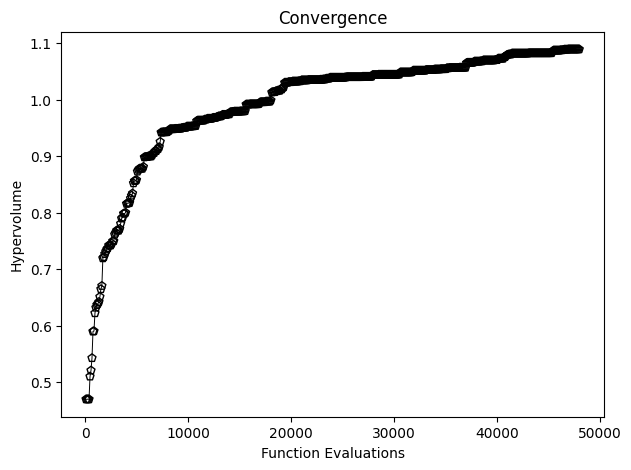

In [14]:
n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

X_res, F_res = res.opt.get("X", "F")

hist = res.history
print(len(hist))
n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population

for algo in hist:

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])
approx_ideal = F_res.min(axis=0)
approx_nadir = F_res.max(axis=0)
from pymoo.indicators.hv import Hypervolume

metric = Hypervolume(ref_point= np.array([1.1, 1.1]),
                     norm_ref_point=False,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

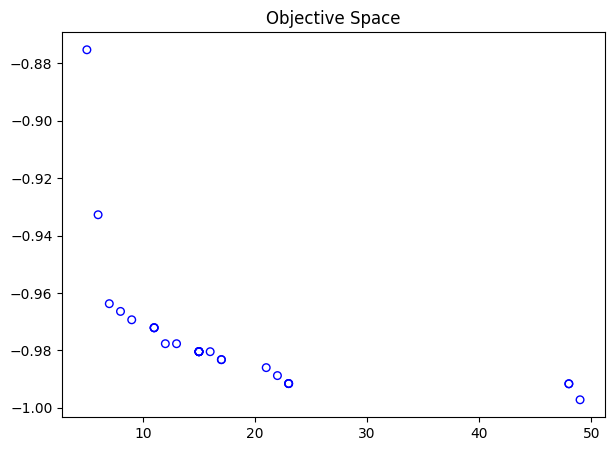

In [15]:
plt.figure(figsize=(7, 5))
plt.scatter(F_res[:, 0], F_res[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()